<a href="https://colab.research.google.com/github/AArchLichKing/CenterNet/blob/Testing-Features/Q5_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question 5

5.2

In [70]:
import csv 
import math

with open("/content/dict.txt",'r') as f:
    rows = f.readlines()

rows = [row.split() for row in rows]
vocabulary = {}
for row in rows:
    vocabulary[row[0]] = row[1]

with open("/content/moviereview.tsv",'r') as f:
    rows = f.readlines()

rows = [row.split('\t') for row in rows]

reviews = [row[1] for row in rows]
y = [2*int(row[0]) - 1 for row in rows]

X = []
for review in reviews:
  feature = {}
  for v in vocabulary: 
      if v in review:
          feature[vocabulary[v]] = 1
  X.append(feature)

print(list(X[10].items())[:10])

[('2', 1), ('5', 1), ('6', 1), ('8', 1), ('17', 1), ('20', 1), ('22', 1), ('25', 1), ('27', 1), ('30', 1)]


5.3

In [79]:
import math

w = [0.0 for i in vocabulary]
lr = 0.1

def exp_func(w, feature, target):
    dot_prod = 0.0
    for i in feature:
        dot_prod += w[int(i)]

    return math.exp(min(-target*dot_prod, 100))
            
def step(epoch):
    grad = [0.0 for i in vocabulary]
    for feature, target in zip(X,y):
      for j in list(feature.keys()):
        grad[int(j)] += exp_func(w, feature, 
                                 target)/(1+exp_func(w, feature, 
                                                     target))*target*feature[j]
    
    for j in range(len(grad)):
        w[j] += lr*grad[j]

def evaluate(w):
    correct = 0
    for feature, target in zip(X,y):
        p = 1/(1+exp_func(w, feature, target))
        p = p >= 0.5
        p = 2*p - 1
        if p == target:
            correct += 1
    print(f"Accuracy: {correct}/{len(y)}, {correct/len(y):.2%}")
    return correct/len(y)


for _ in range(30):
    print("Training for epoch {}".format(_))
    step(_)

acc = evaluate(w)

Training for epoch 0
Training for epoch 1
Training for epoch 2
Training for epoch 3
Training for epoch 4
Training for epoch 5
Training for epoch 6
Training for epoch 7
Training for epoch 8
Training for epoch 9
Training for epoch 10
Training for epoch 11
Training for epoch 12
Training for epoch 13
Training for epoch 14
Training for epoch 15
Training for epoch 16
Training for epoch 17
Training for epoch 18
Training for epoch 19
Training for epoch 20
Training for epoch 21
Training for epoch 22
Training for epoch 23
Training for epoch 24
Training for epoch 25
Training for epoch 26
Training for epoch 27
Training for epoch 28
Training for epoch 29
Accuracy: 1200/1200, 100.00%


# Question 6

6.1

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

testset_url  = "/content/Titanic.csv"
df = pd.read_csv(testset_url)
df = df.dropna(axis=1)
df.Sex = df["Sex"].map({'male':0, 'female':1})
X = df.iloc[:, 1:].to_numpy()
y = df.iloc[:, 0].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=522)

6.2

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import time


rfc = RandomForestClassifier()
start_time = time.time()
rfc.fit(X_train, y_train)
print(f"Fitting Random Forest requires {time.time()-start_time:.2f}s")


gbc = GradientBoostingClassifier()
start_time = time.time()
gbc.fit(X_train, y_train)
print(f"Fitting Gradient Boost requires {time.time()-start_time:.2f}s")

Fitting Random Forest requires 0.18s
Fitting Gradient Boost requires 0.09s


The gradient boosting method requires less time for training. If we look at the default hyper-parameters, we can see that the max_depth of gradient boosting is fixed as 3, while random forest does not fix the max_depth, its nodes are expanded until all leaves are pure, which leads to higher training time. 

6.3

In [ ]:
# I am playing with n_estimators and max_depth
from sklearn.model_selection import GridSearchCV

parameters = {'n_estimators':[20, 100, 500], 'max_depth':[3, 5]}
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()

rfc_gs = GridSearchCV(rfc, parameters, cv=5)
gbc_gs = GridSearchCV(gbc, parameters, cv=5)

rfc_gs.fit(X_train, y_train)
gbc_gs.fit(X_train, y_train)

print("Finish the cross validation")

Finish the cross validation


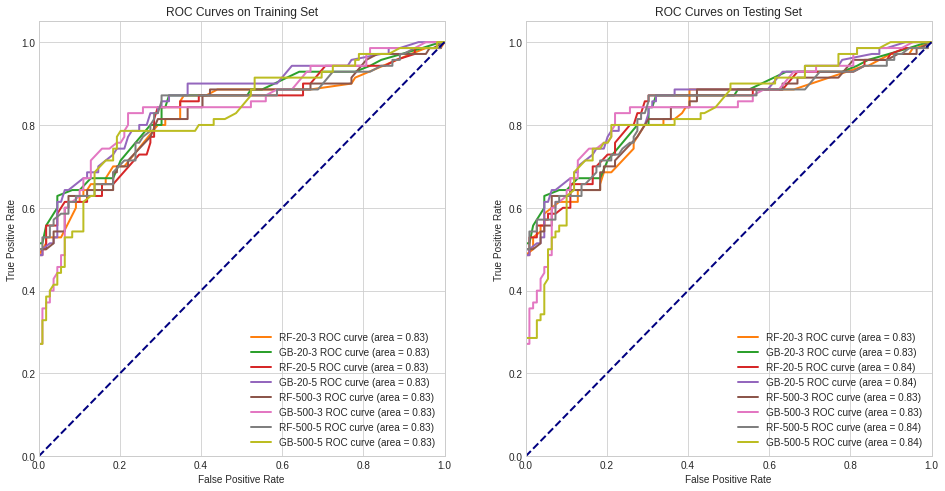

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.colors as mcolors

fig, axes = plt.subplots(1,2, figsize=[16,8])
axes[0].title.set_text("ROC Curves on Training Set")
axes[1].title.set_text("ROC Curves on Testing Set")

cmap=[c[1] for c in list(mcolors.TABLEAU_COLORS.items())] + [c[1] for c in list(mcolors.BASE_COLORS.items())]
lw = 2
dataset = [(X_train, y_train), (X_test, y_test)]

for ax_id in range(len(dataset)):
    k=0
    for n_estimators in [20, 500]:
        for max_depth in [3, 5]:
            rfc = RandomForestClassifier(n_estimators=n_estimators, 
                                        max_depth=max_depth)
            gbc = GradientBoostingClassifier(n_estimators=n_estimators, 
                                            max_depth=max_depth)

            X, y = dataset[i]
            y = np.hstack([1-y.reshape(-1,1),y.reshape(-1,1)])
            rfc_score = rfc.fit(X_train, y_train).predict_proba(X)
            gbc_score = gbc.fit(X_train, y_train).predict_proba(X)

            rfc_fpr = dict()
            rfc_tpr = dict()
            rfc_roc_auc = dict()
            for i in range(2):
                rfc_fpr[i], rfc_tpr[i], _ = roc_curve(y[:, i], rfc_score[:, i])
                rfc_roc_auc[i] = auc(rfc_fpr[i], rfc_tpr[i])

            gbc_fpr = dict()
            gbc_tpr = dict()
            gbc_roc_auc = dict()
            for i in range(2):
                gbc_fpr[i], gbc_tpr[i], _ = roc_curve(y[:, i], gbc_score[:, i])
                gbc_roc_auc[i] = auc(gbc_fpr[i], gbc_tpr[i])
            
            k+=1
            axes[ax_id].plot(
                rfc_fpr[1],
                rfc_tpr[1],
                color=cmap[k],
                lw=lw,
                label=f"RF-{n_estimators}-{max_depth} ROC curve (area = {rfc_roc_auc[1]:0.2f})",
            )
            k+=1
            axes[ax_id].plot(
                gbc_fpr[1],
                gbc_tpr[1],
                color=cmap[k],
                lw=lw,
                label=f"GB-{n_estimators}-{max_depth} ROC curve (area = {rfc_roc_auc[1]:0.2f})",
            )


        
axes[0].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend(loc="lower right")

axes[1].plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend(loc="lower right")

plt.show()

Similarity, the affect of selected two hyper parameters have very similar effect on both models. 

# Question 7

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Train Accuracy： 68.50%, Test Accuracy： 76.81%


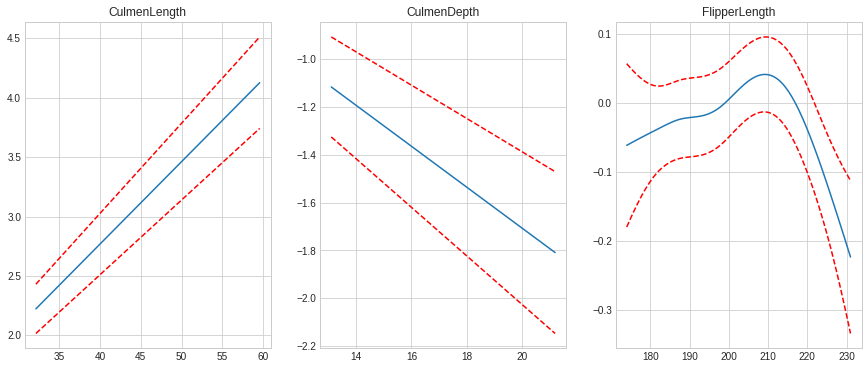

In [104]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pygam import LinearGAM,LogisticGAM,l,s,f

testset_url  = "/content/penguins_trunc.csv"
df = pd.read_csv(testset_url)
X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=1)

feature_names = ['CulmenLength','CulmenDepth','FlipperLength']

linear_gam = LinearGAM(l(0)+l(1)+s(2))
linear_gam.gridsearch(X_train,y_train)

train_pred = linear_gam.predict(X_train)
train_pred[train_pred > 0] = 1
train_pred[train_pred < 0] = 0
train_acc = sum(train_pred == y_train)/len(y_train)

test_pred = linear_gam.predict(X_test)
test_pred[test_pred > 0] = 1
test_pred[test_pred < 0] = 0
test_acc = sum(test_pred == y_test)/len(y_test)

print(f"Train Accuracy： {train_acc:.2%}, Test Accuracy： {test_acc:.2%}")

fig, axes = plt.subplots(1, 3,figsize=(15,6))
titles = feature_names

for i, ax in enumerate(axes):
    XX = linear_gam.generate_X_grid(term=i)
    pdep, confi = linear_gam.partial_dependence(term=i, width=.95)

    plt.subplot(axes[i])
    plt.plot(XX[:, i], pdep)
    plt.plot(XX[:, i], confi, c='r', ls='--')
    plt.title(titles[i])